# Solver examples rundown

This notebook is intended to demonstrate how to use the BanditSolvers library and to hopefully convince you of its efficacy when solving k-armed bandit problems.

## Basic simulations
This first part is intended as a summary analysis of the basic examples simulations.
The functions it runs are meant to be the basic examples that should be studied to understand how to use the library

### Methodology
The methodology for this simulation is as follow:
* for each solver a simulation is run
* each solver simulation is independent of the others
* the target are generated from 2 gamma distributions that are sampled each time its associated action is called
* For each simulation the parameters for the gamma distributions are the same
* The parameters of each solver are the same except for the unique parameters associated with each type

The solvers parameters are as follow:
```[python3]
    # General params
    optimistic_value=5.
    step_size=1e-2

    # epsilon
    epsilon=1e-2

    # ucb
    confidence=1e-2
```

#### Actions analysis
The gamma distributions parameters are as follow:
```[python3]
    # action_a
    alpha=0.5
    loc=0
    scale=1

    # action_b
    alpha=0.1
    loc=0
    scale=1
```
Which yields the following density functions

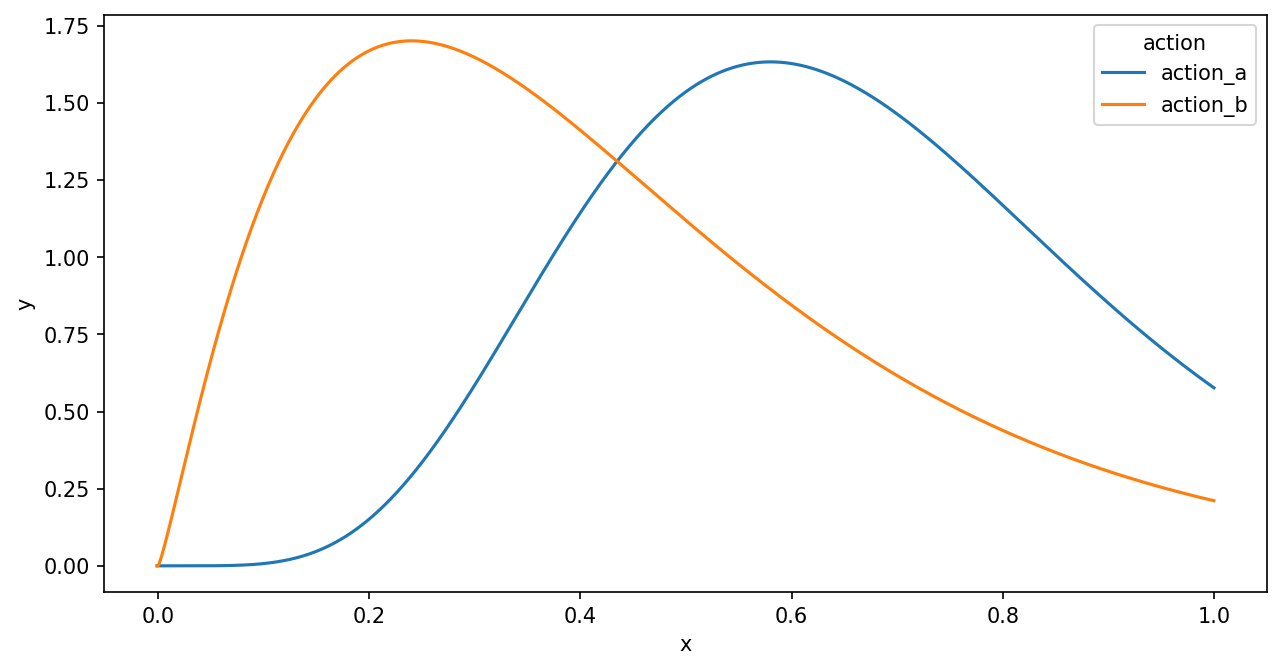

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame, concat
from scipy.stats import gamma

x: np.ndarray[np.float64] = np.linspace(-0.001, 1, 1000)

action_a_y: np.ndarray[np.float64] = gamma.pdf(x, a=6.8, scale=0.1, loc=0)
action_b_y: np.ndarray[np.float64] = gamma.pdf(x, a=2.2, scale=0.2, loc=0)

action_a_pdf_df = DataFrame({
    'x': x,
    'y': action_a_y,
    'action': 'action_a'
})

action_b_pdf_df = DataFrame({
    'x': x,
    'y': action_b_y,
    'action': 'action_b'
})

actions_pdf_df: DataFrame = concat([action_a_pdf_df, action_b_pdf_df])

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] =150
plt.figure(figsize=(10, 5))

f = sns.lineplot(actions_pdf_df, x='x', y='y', hue='action')

Thanks to this graphic we see that of our two actions the clear winner is action_a, But there is still a decent overlap in the values that can be returned between the actions, which could lead to some confusion if we were to try and solve the problem manually

### Basic Simulation execution

In [94]:
from pandas import DataFrame
from Exemples.basic_exemples import run_basic_exemples

base_examples_df: DataFrame = run_basic_exemples()
base_examples_df

/home/vi/Projects/personal/bandit_maker/BanditAgents/src/solvers/sampling_solver.py:170: RuntimeWarning: Degrees of freedom <= 0 for slice
  if training_targets.var() > 0:
/home/vi/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/vi/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,steps,action_indexes,action_keys,targets,simulation
0,0,1,action_b,0.577613,weighted
1,1,0,action_a,0.493912,weighted
2,2,0,action_a,0.707548,weighted
3,3,1,action_b,0.706908,weighted
4,4,1,action_b,0.399854,weighted
...,...,...,...,...,...
95,95,0,action_a,0.441052,sampling
96,96,0,action_a,1.007556,sampling
97,97,0,action_a,0.484787,sampling
98,98,0,action_a,0.581317,sampling


As can be seen the result of this execution is a dataframe in which each row represents a decision.

Each row contains: 
* the step at which the decision was take
* the decision taken
* its associated target
* the solver that was used to take the decision

To illustrate that it might be hard to interpret the data based only on the resulting targets of the actions here is a plot of the targets obtained after each solver's decisions

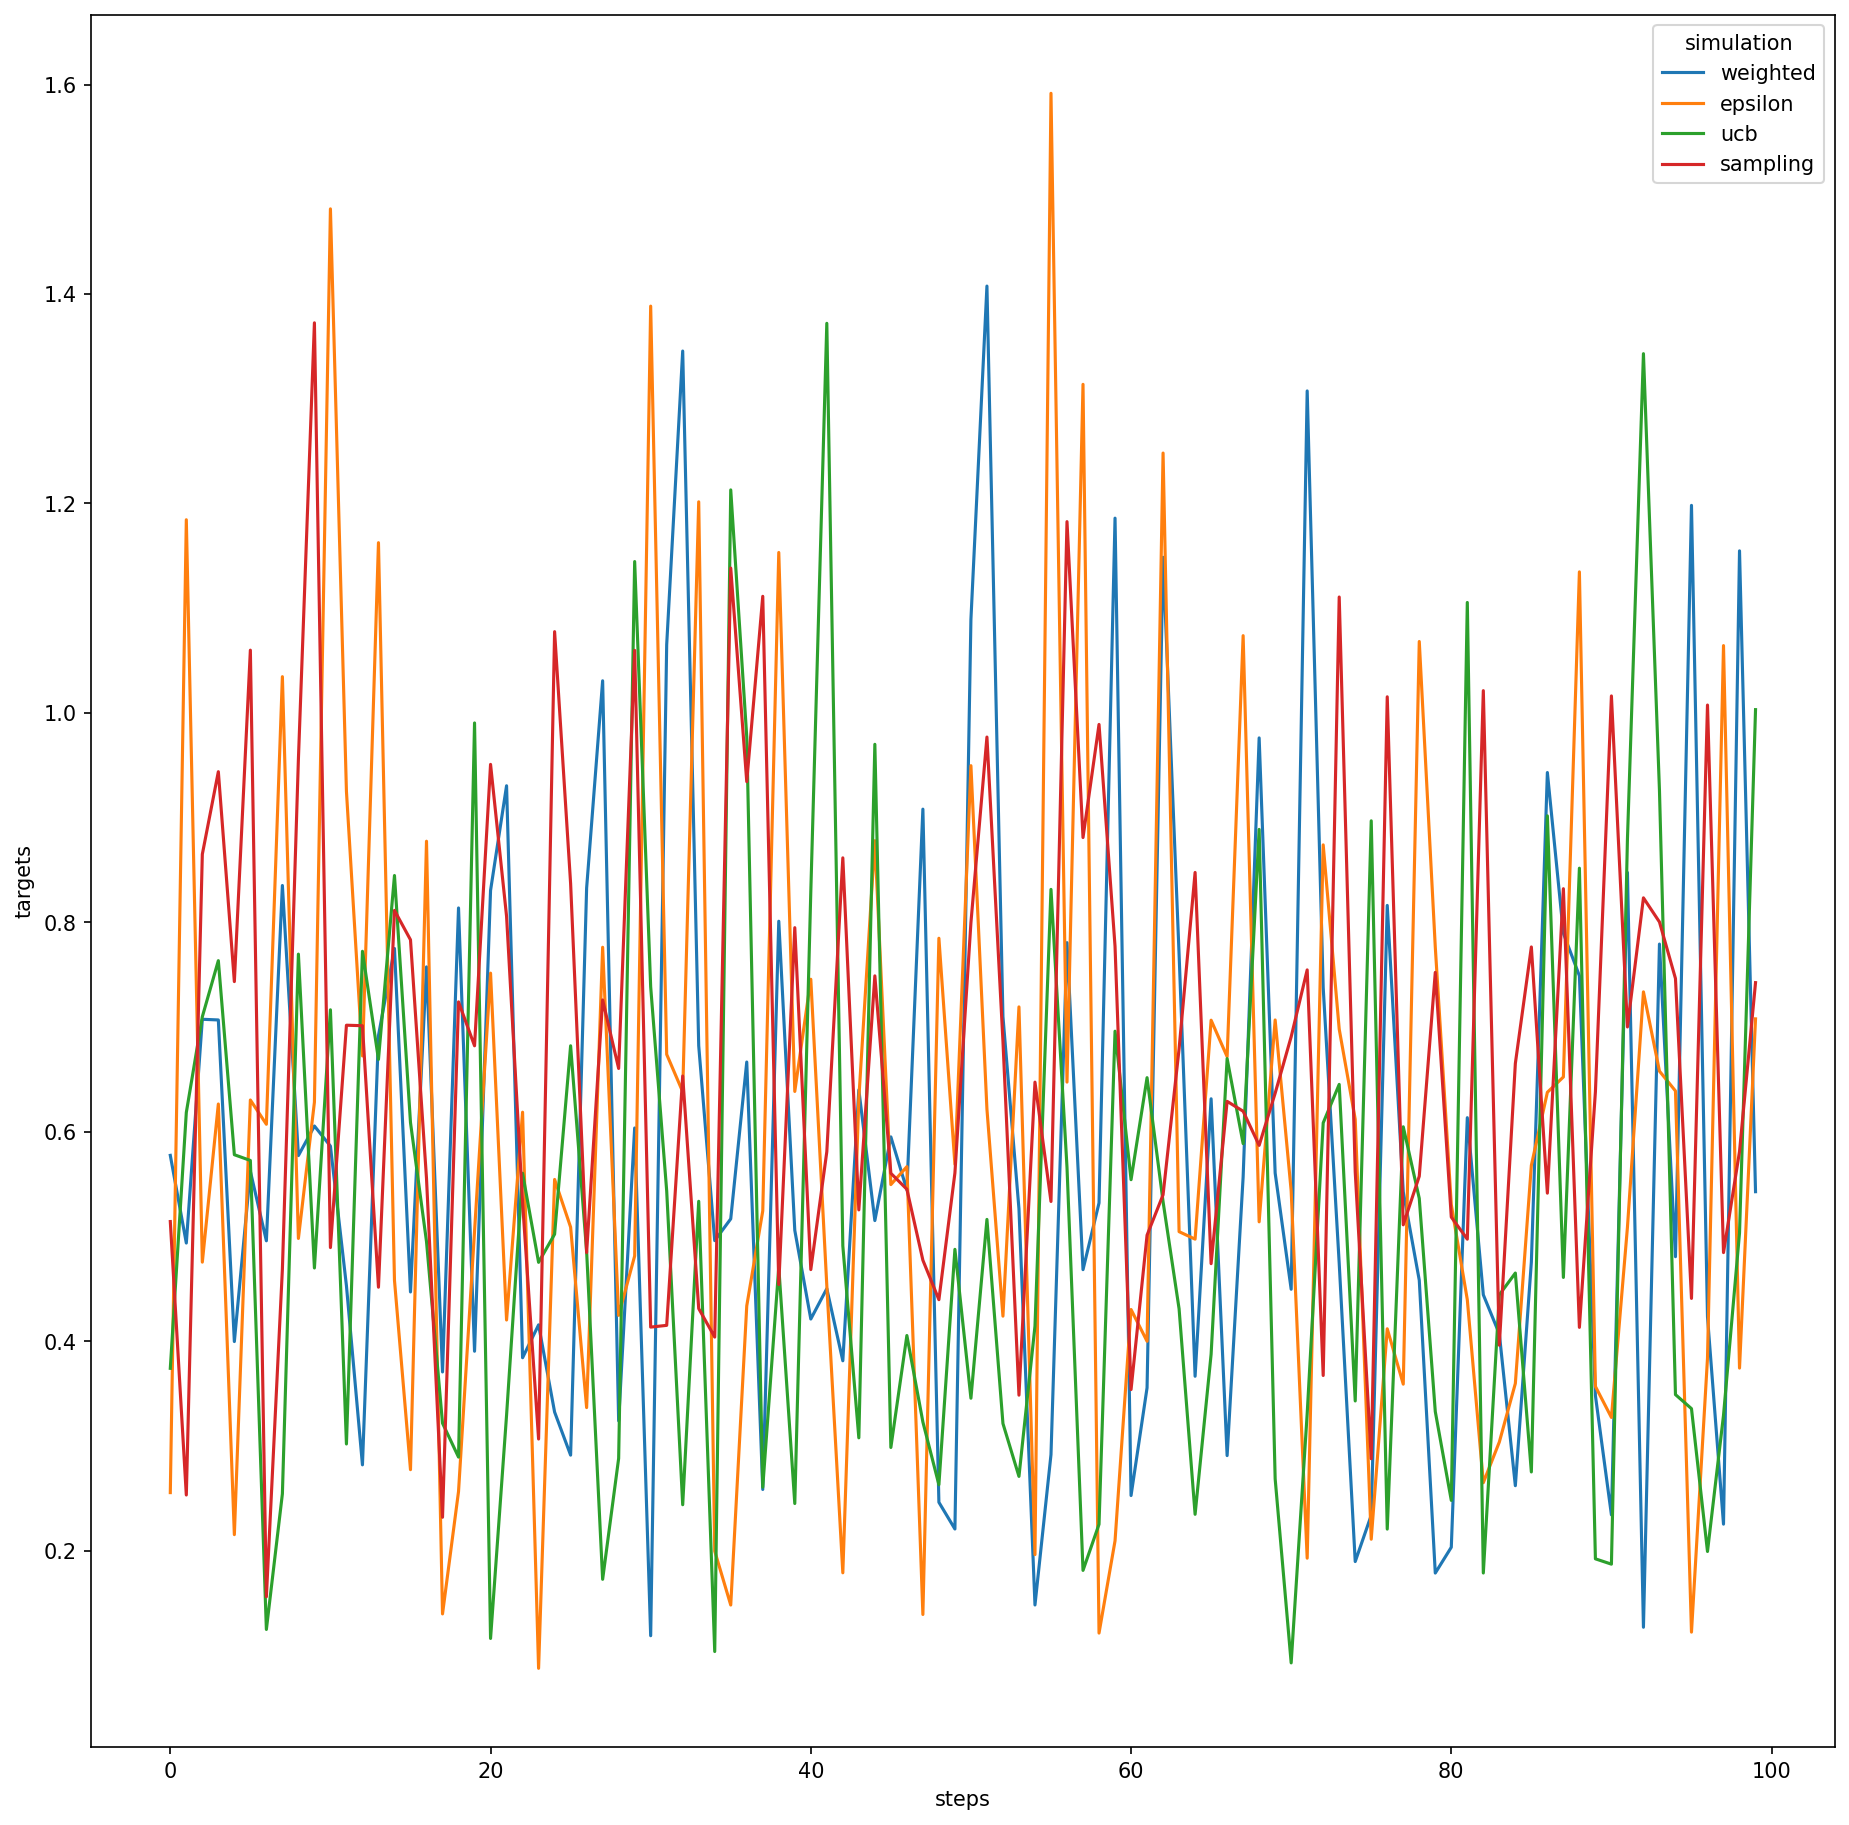

In [95]:
from matplotlib.axes._axes import Axes


f: Axes = sns.lineplot(
    base_examples_df.loc[base_examples_df.steps < 100], 
    x='steps', 
    y='targets', 
    hue='simulation'
)

Since we know which distribution is best and these results are hard to interpret we will instead look at the number of times each solver called the right action

<Axes: xlabel='simulation', ylabel='count'>

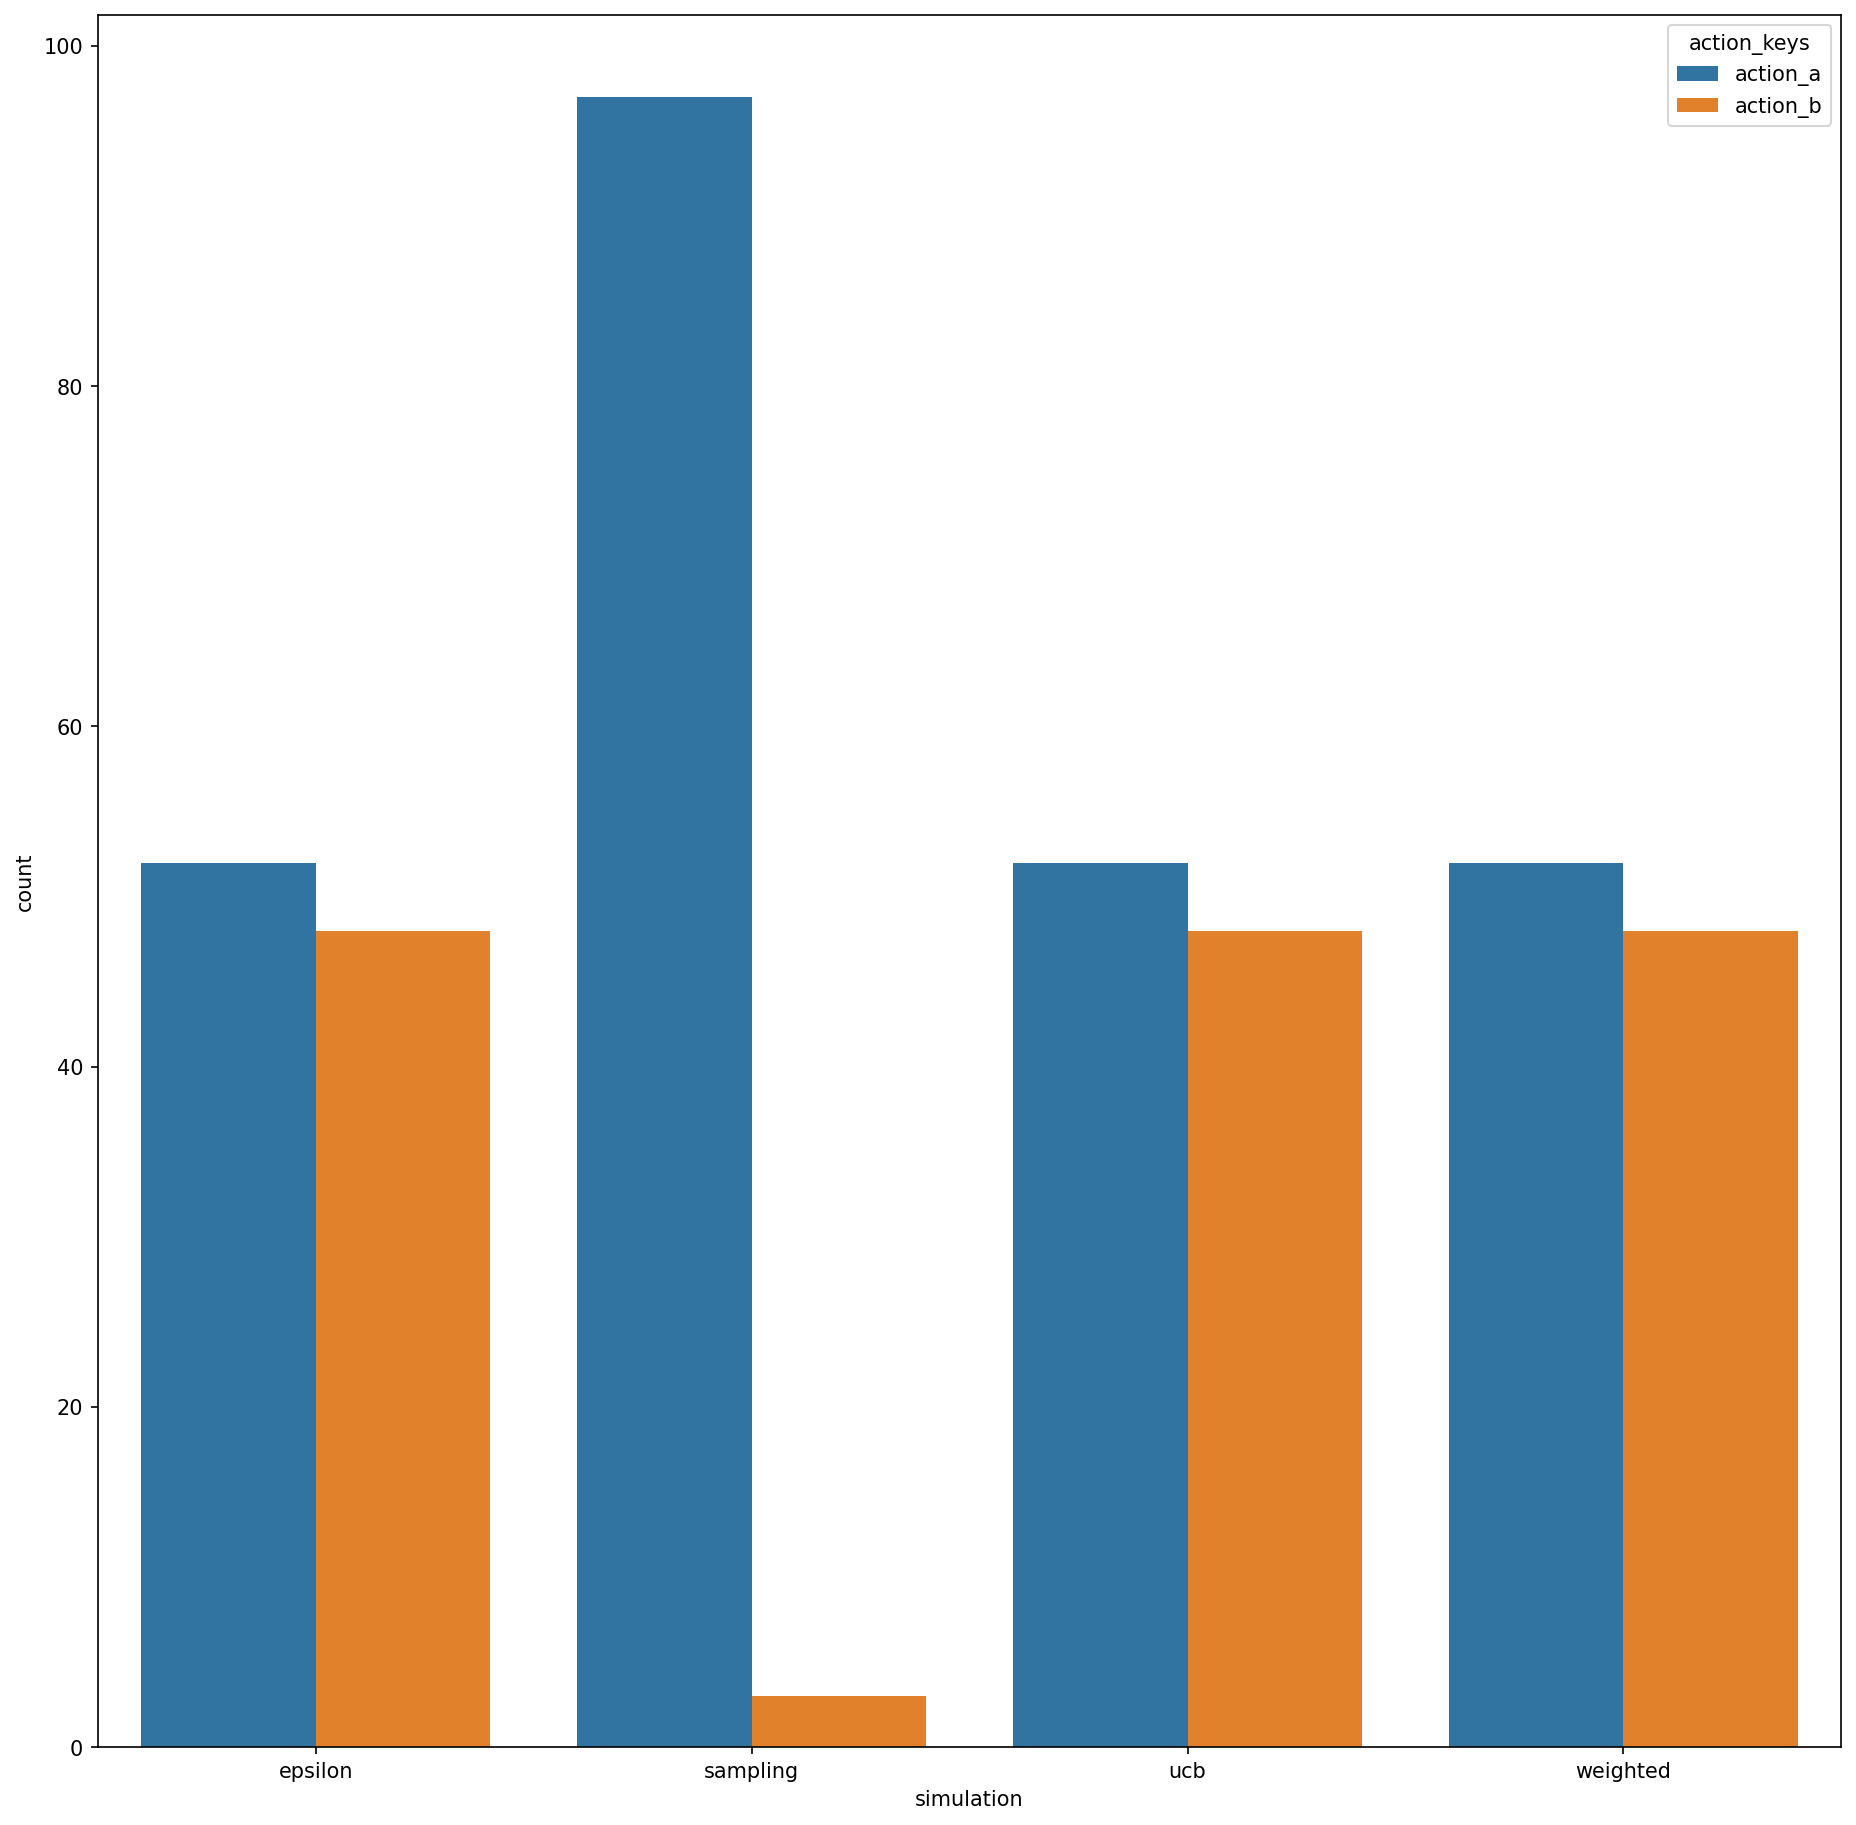

In [96]:
base_examples_action_count_df = (
    base_examples_df[['simulation', 'action_keys']]
    .groupby(['simulation', 'action_keys'])['action_keys']
    .count()
    .to_frame(name='count')
    .reset_index()
)

sns.barplot(
    base_examples_action_count_df,
    x='simulation',
    y='count',
    hue='action_keys'
)


We can see that in this context the better solver is the Sampling solver!

The sampling solver chose the better action more often than the other solvers. This means that if you let the solvers run for a large number of epochs necessarily the sampling solver will yield more reward than the others. This reality is true for a large number of epochs if you are dealing with a situation where you have a limited number of choices you can make you might find out that another solver will perform best.

To illustrate this situation we can take a look at our basic simulations and their performances.

In [97]:
cummulative_targets_df: DataFrame = base_examples_df.groupby('simulation').targets.sum()
cummulative_targets_df

simulation
epsilon     60.442874
sampling    67.379652
ucb         52.461685
weighted    58.582469
Name: targets, dtype: float64

We see that the sampling solver performs best but not by much and fora 100 epochs.

Note: Given the nature of the test: 1 simulation per solver, this performance comparison is not a valid one.

The next section will be about comparing performance of different solvers given different contexts

### performance simulations
We first run the simulations

In [98]:
from pandas.core.frame import DataFrame
from Exemples.performance_exemples import run_performance_exemples


performance_simulations_results: DataFrame = run_performance_exemples()
performance_simulations_results

,steps,action_indexes,action_keys,targets,simulation
0,0,0,action_a,0.448014,epsilon_1
1,1,1,action_b,0.119032,epsilon_1
2,2,1,action_b,0.300845,epsilon_1
3,3,0,action_a,0.400416,epsilon_1
4,4,0,action_a,0.553747,epsilon_1
...,...,...,...,...,...
995,995,0,action_a,0.475218,weight_1
996,996,0,action_a,0.436245,weight_1
997,997,0,action_a,0.614136,weight_1
998,998,0,action_a,0.397830,weight_1


#### basic performances exemple
This exemple uses the same actions as the previous example but this time we compare the performances of each agent relative to the others. To do so we make the simulation generate the targets before applying the solver's choices. This is done through a SimulationAgent object.

##### Methodology
The methodology for this simulation is as follow:
* for each solver a simulation is run
* each solver simulation is independent of the others
* the target are generated from 2 gamma distributions that are sampled each time its associated action is called
* For each simulation the parameters for the gamma distributions are the same
* The parameters of each solver are the same except for the unique parameters associated with each type

The solvers parameters are as follow:
```[python3]
epsilon_solvere_hyperparams = EpsilonSolverHyperParameters(
    solver_id="epsilon_1"
)
sampling_solver_hyperparams = SamplingSolverHyperParameters(
    solver_id="sampling_1"
)
ucb_solver_hyperparams = UCBSolverHyperParameters(solver_id="ucb_1")
weight_solver_hyperparams = WeightSolverHyperParameters(
    solver_id="weight_1"
)
```

###### Actions analysis
The gamma distributions parameters are as follow:
```[python3]
actions: Tuple[Tuple[str, Tuple[float, float, float]]] = (
    ("action_a", (6.8, 0, 0.1)),
    ("action_b", (2.2, 0, 0.2)),
)
```
Which yields the following density functions

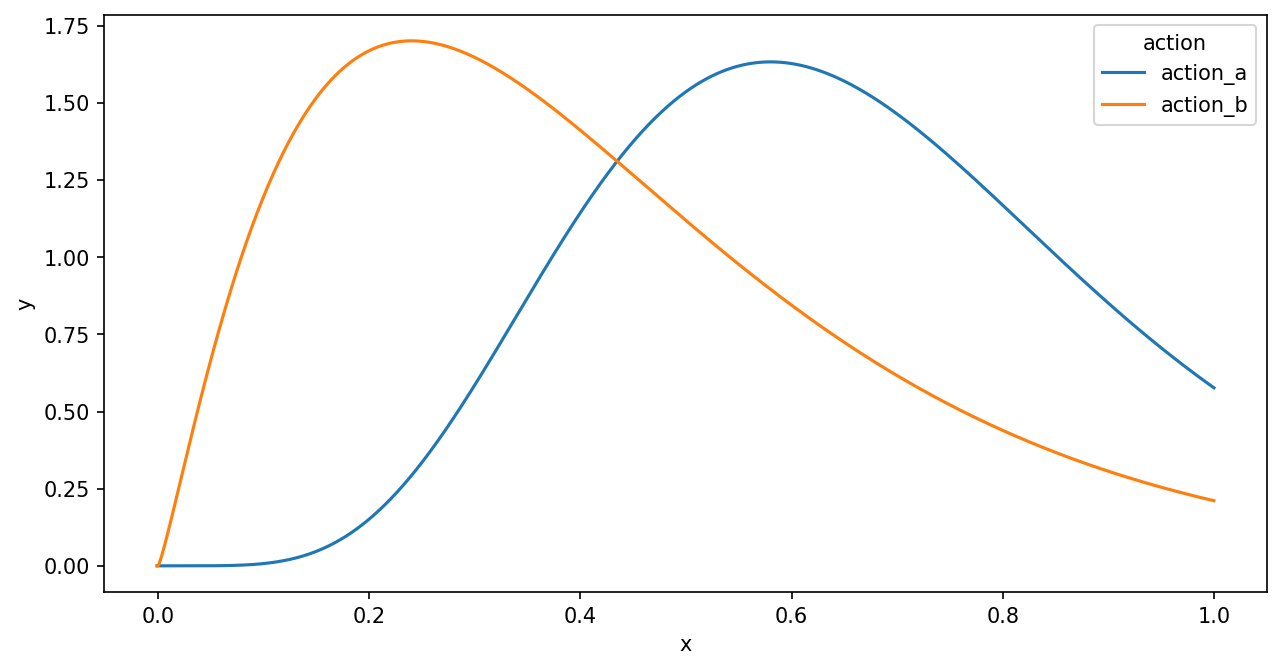

In [99]:
x: np.ndarray[np.float64] = np.linspace(-0.001, 1, 1000)

action_a_y: np.ndarray[np.float64] = gamma.pdf(x, a=6.8, scale=0.1, loc=0)
action_b_y: np.ndarray[np.float64] = gamma.pdf(x, a=2.2, scale=0.2, loc=0)

action_a_pdf_df = DataFrame({
    'x': x,
    'y': action_a_y,
    'action': 'action_a'
})

action_b_pdf_df = DataFrame({
    'x': x,
    'y': action_b_y,
    'action': 'action_b'
})

actions_pdf_df: DataFrame = concat([action_a_pdf_df, action_b_pdf_df])

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] =150
plt.figure(figsize=(10, 5))

f = sns.lineplot(actions_pdf_df, x='x', y='y', hue='action')

Now let's start analysing the solvers performances

This time the performance comparison is actually much easier to interpret

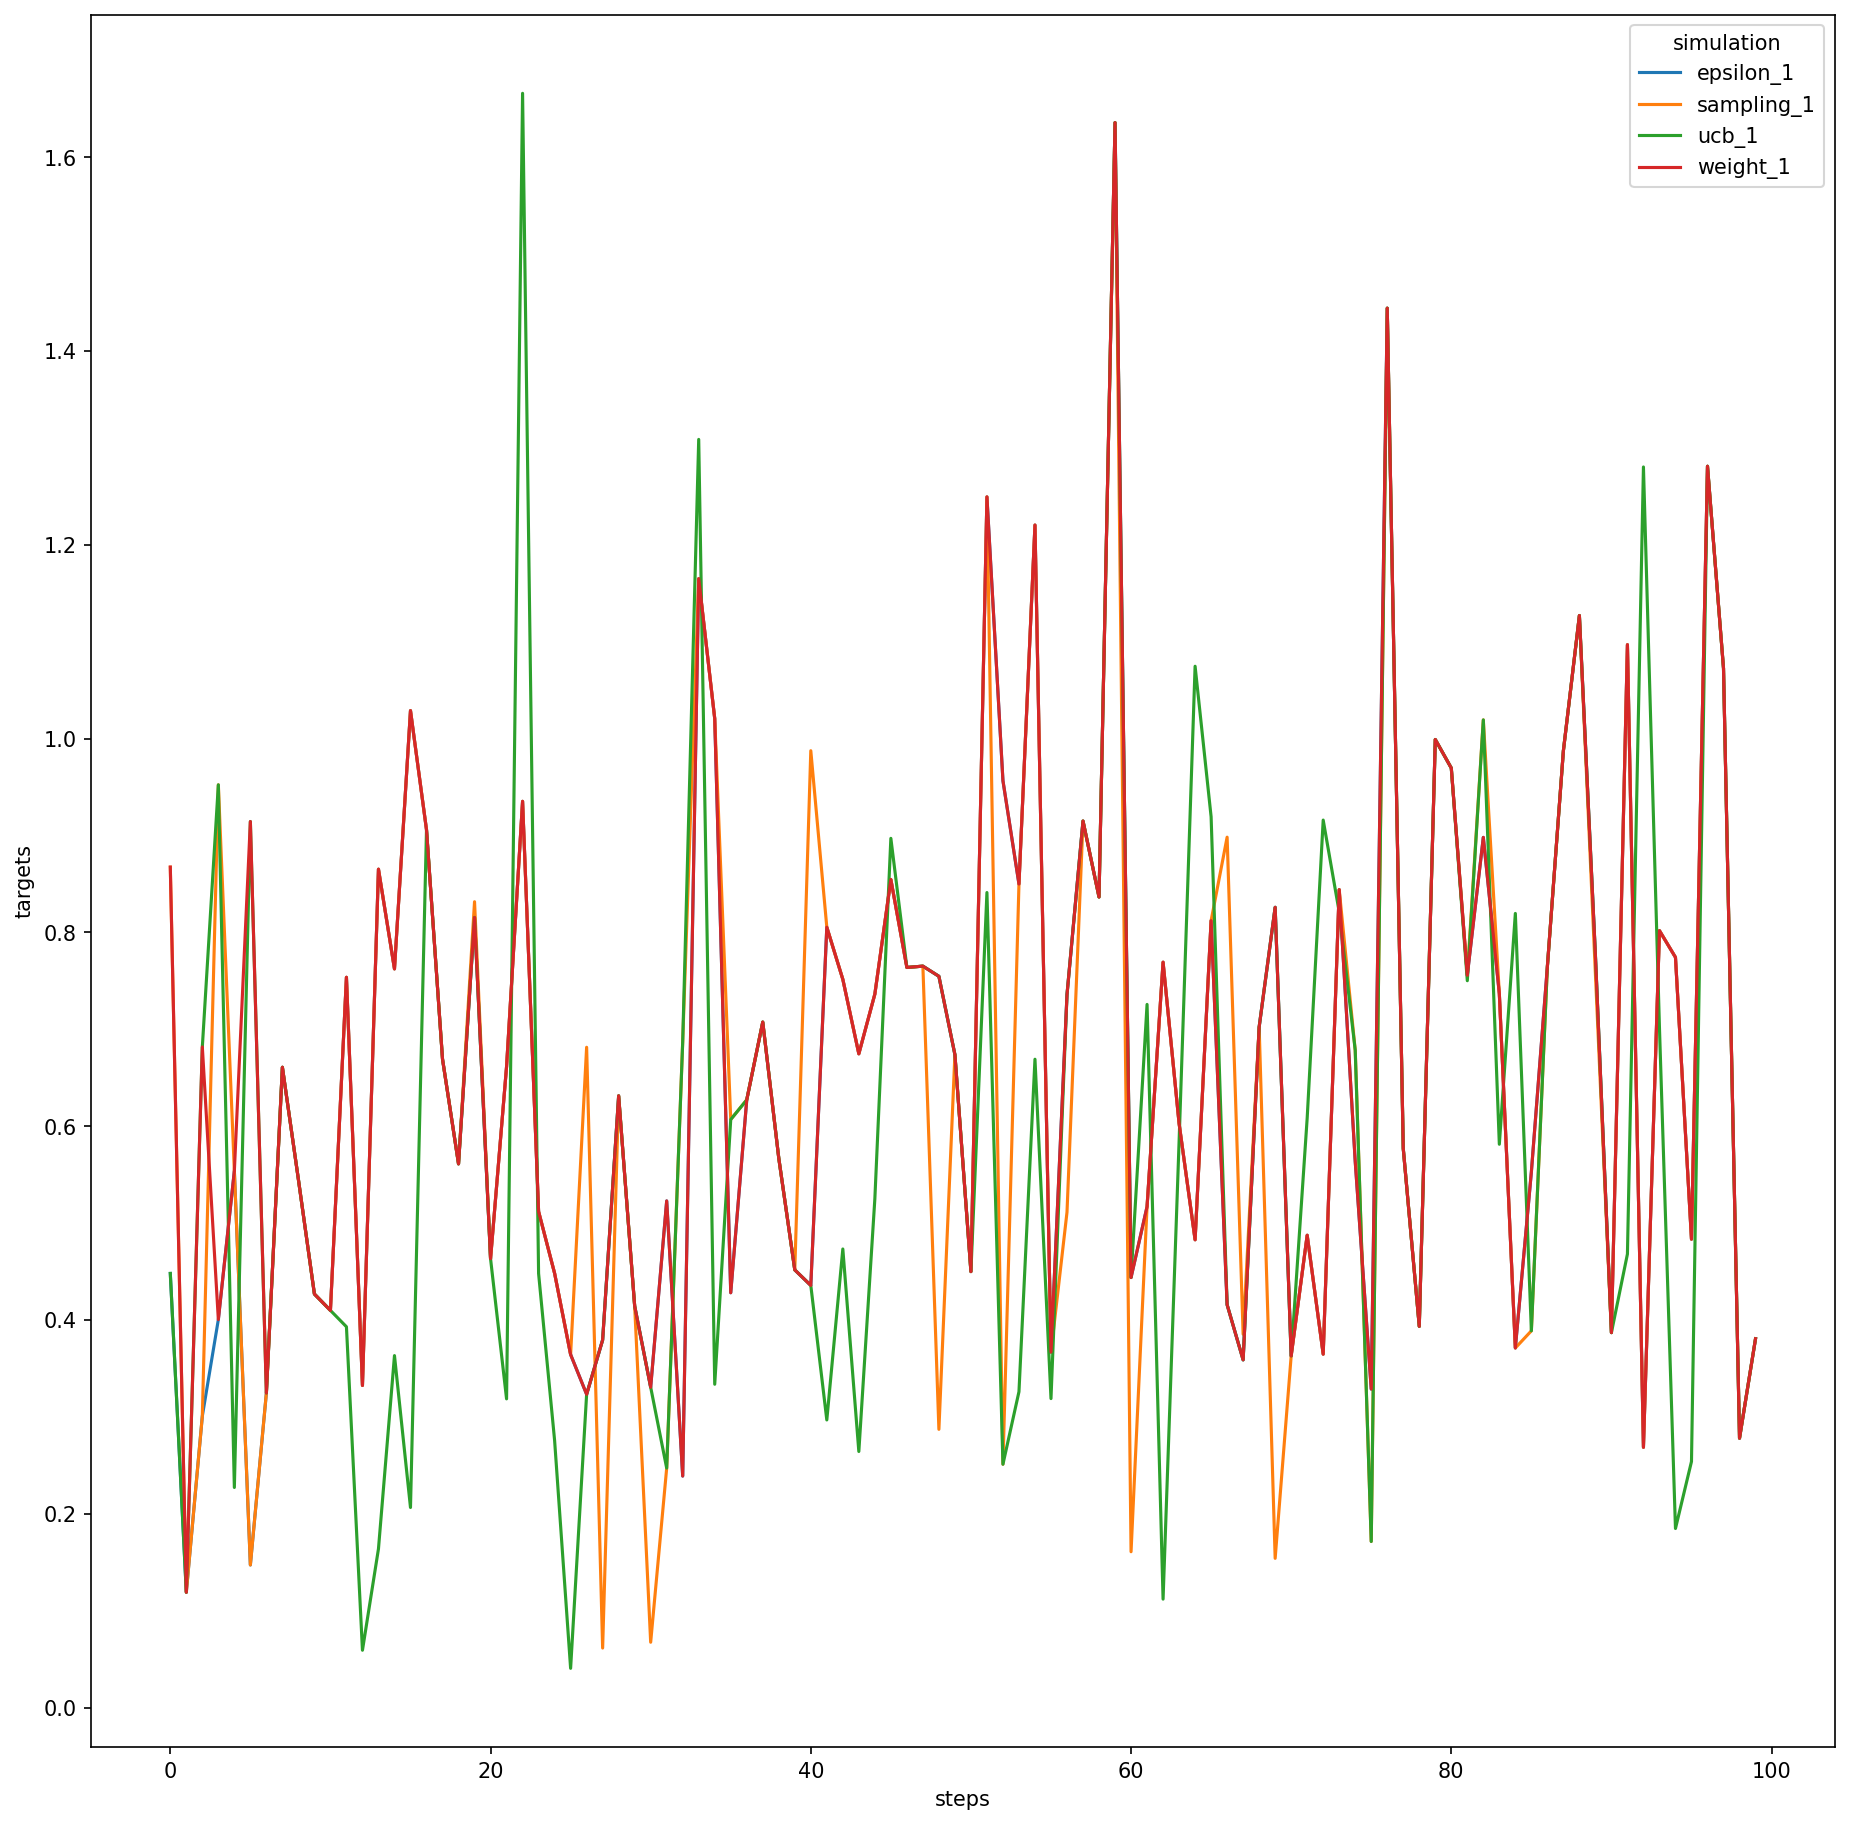

In [100]:
from pandas import DataFrame


basic_performance_comparison_df: DataFrame = performance_simulations_results

f: Axes = sns.lineplot(
    basic_performance_comparison_df.loc[basic_performance_comparison_df.steps < 100], 
    x='steps', 
    y='targets', 
    hue='simulation'
)

Let's make it even clearer

simulation
epsilon_1     686.534332
sampling_1    634.004091
ucb_1         588.610455
weight_1      688.101734
Name: targets, dtype: float64

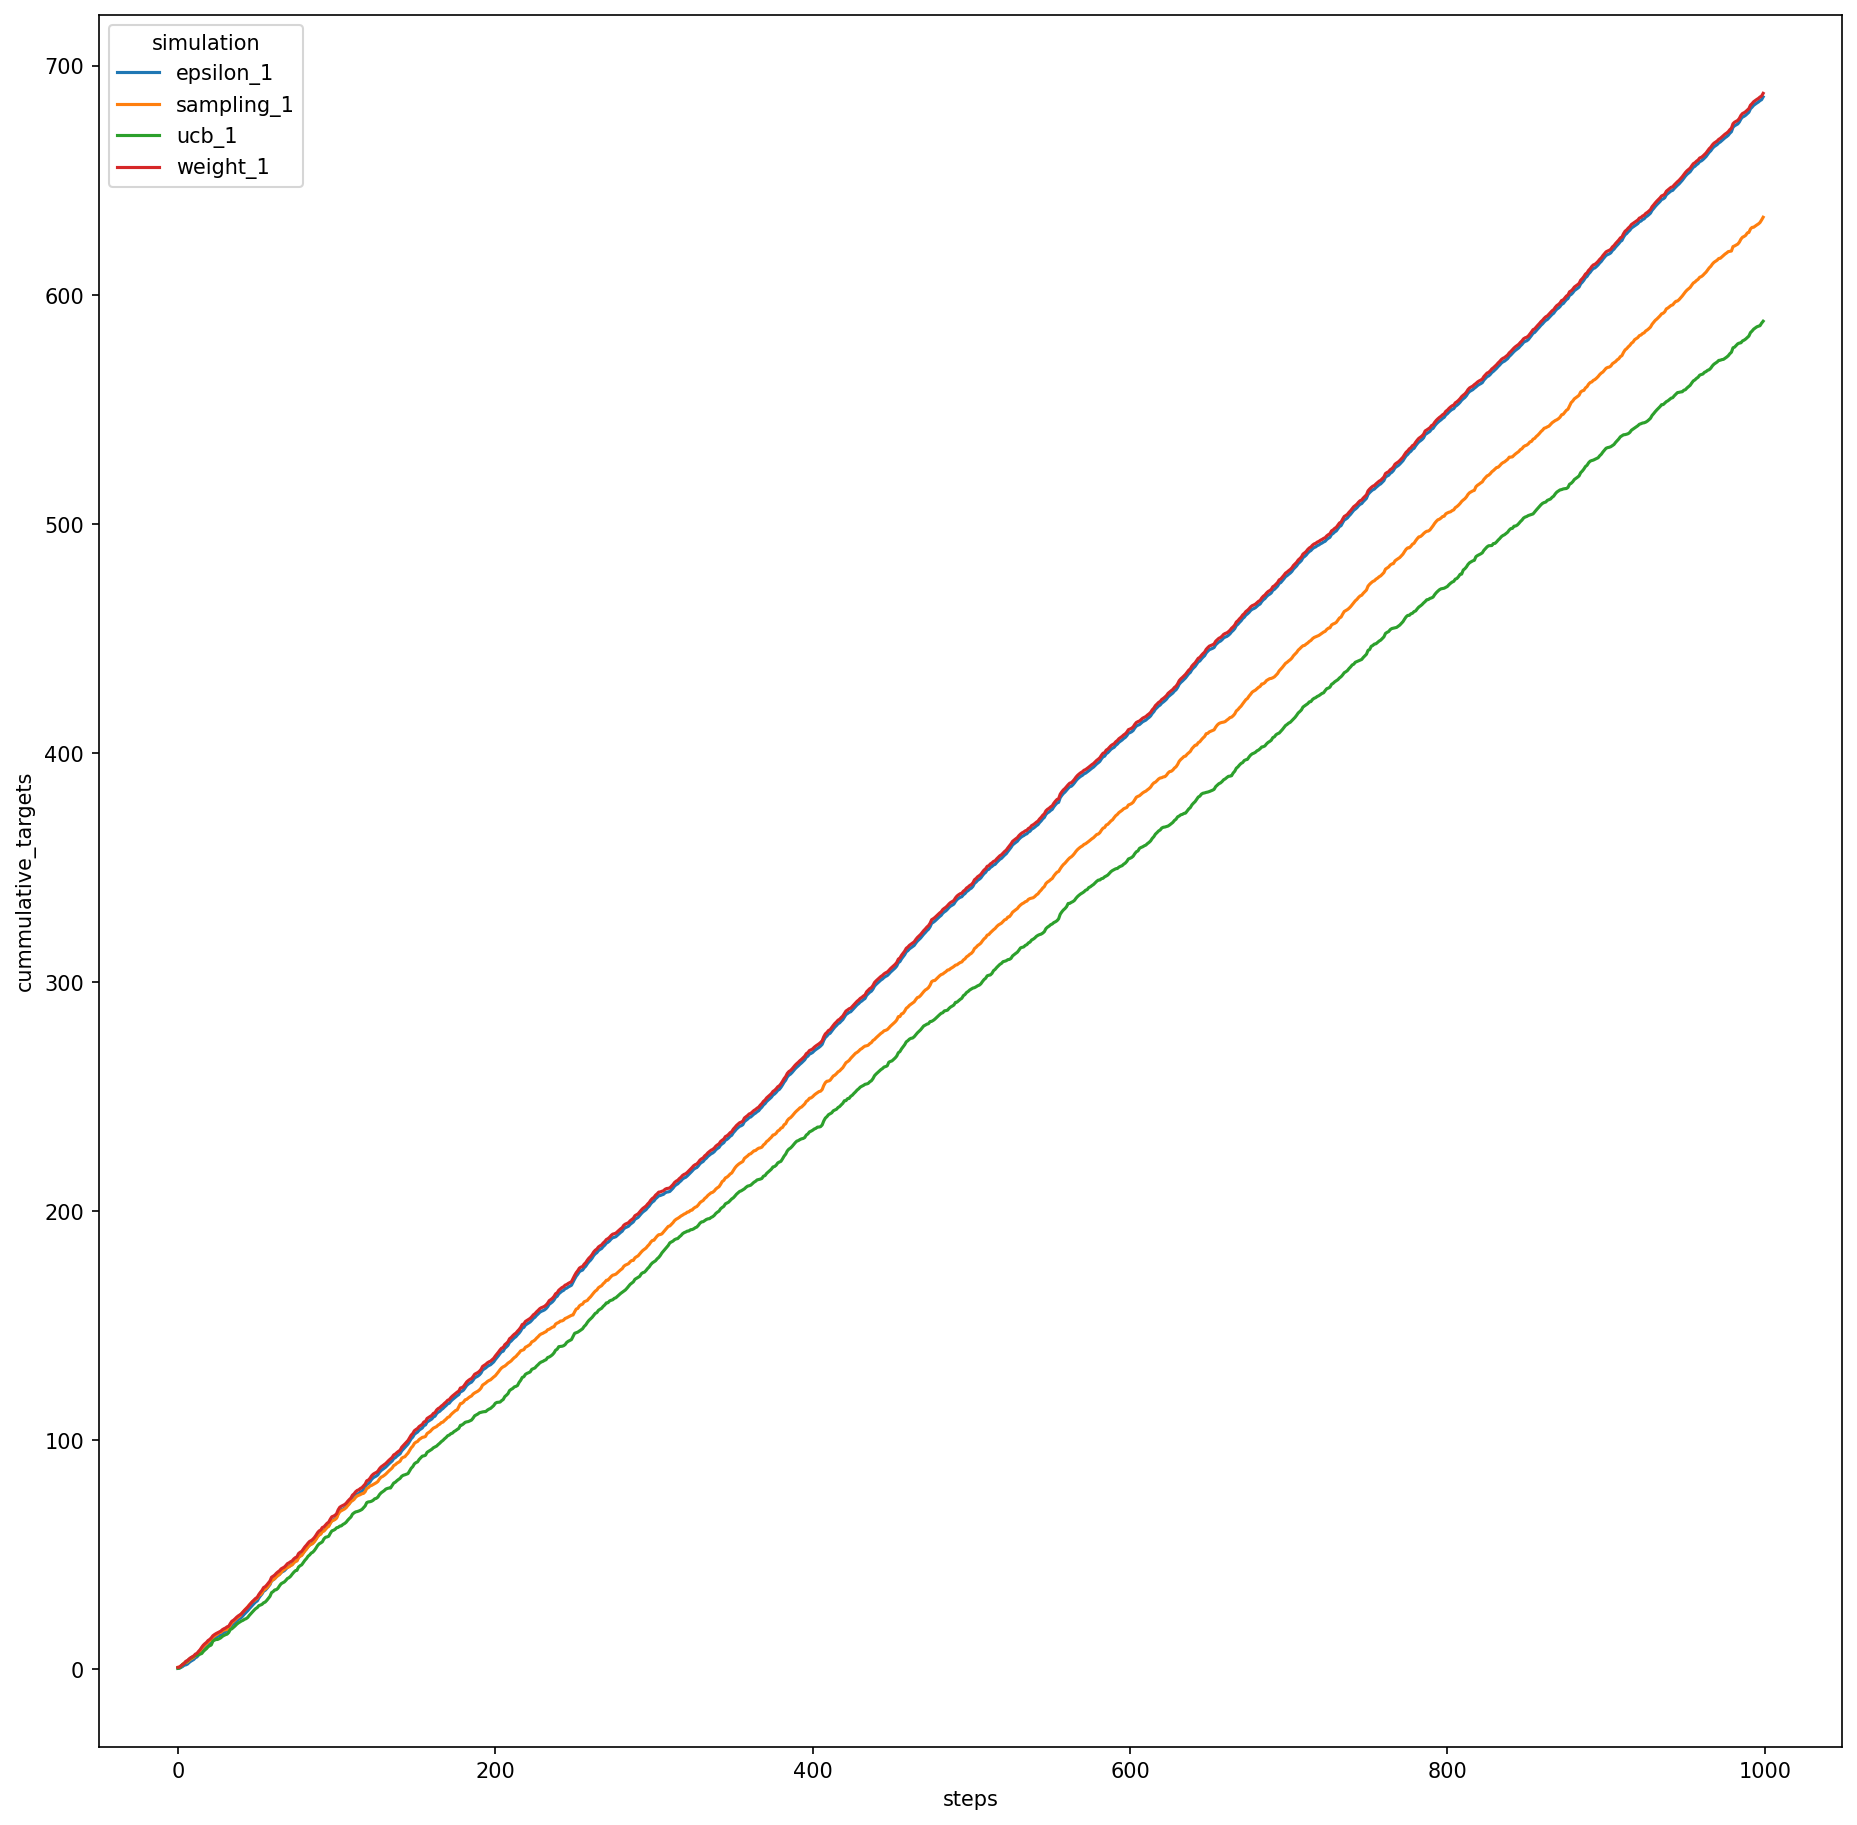

In [102]:
basic_performance_comparison_df['cummulative_targets'] = basic_performance_comparison_df.groupby(['simulation']).targets.cumsum()

f: Axes = sns.lineplot(
    basic_performance_comparison_df.loc[basic_performance_comparison_df.steps < 1000], 
    x='steps', 
    y='cummulative_targets', 
    hue='simulation'
)

basic_performance_comparison_df.groupby('simulation').targets.sum()

You can run it multiple times and the results will vary. But in the case of this precise run the better solver is the weighted one. This is explained by the context and the hyperparameters.